In [1]:
using Plots
using LinearAlgebra
using Parameters
using StaticArrays
using Roots

In [2]:
module My

using Parameters
using StaticArrays

@with_kw struct PhysicalParam{T₁, T₂, T₃} @deftype Float64 
    ħc = 200 # [MeV fm]
    mc² = 1000 # nucleon mass [MeV]
    M = ħc^2/2mc² # [MeV fm²]
    
    U₀ = -55 # hartree-fock potential [MeV]
    V₀ = -3 # pairing potential [MeV]
    r₀ = 5 # radius [fm]
    λ = -8 # chemical potential [MeV]
    
    Nr::Int64 = 100
    Δr = 0.1 # [fm]
    rs::T₁ = range(0, Nr*Δr, length=Nr+1)
    
    ir_matching::Int64 = floor(Int, r₀/Δr) + 1
    
    # buffer
    ys_1p::T₂ = zeros(Float64, 2, Nr+1)
    ys_2p::T₂ = zeros(Float64, 2, Nr+1)
    ys_1m::T₂ = zeros(Float64, 2, Nr+1)
    ys_2m::T₂ = zeros(Float64, 2, Nr+1)
    
    Gs::T₂ = zeros(Float64, 2, Nr+1)
    
    As::T₃     = zeros(Float64, 2, 2, Nr+1)
    As_inv::T₃ = zeros(Float64, 2, 2, Nr+1)
end

@with_kw struct HFBstates
    nstates_max::Int64
    
    # quasiparticle energies
    qpEs::Vector{Float64}
    @assert length(qpEs) === nstates_max
    
    # HFB wave functions
    wfs::Array{Float64, 3} 
    @assert size(wfs, 1) === 2
    @assert size(wfs, 3) === nstates_max
end

end # module My

Main.My

In [3]:
function make_HFBstates(param; nstates_max=1000)
    @unpack Nr = param 
    
    qpEs  = zeros(Float64, nstates_max)
    qpEs .= 1e10
    
    wfs  = zeros(Float64, 2, Nr+1, nstates_max)
    
    My.HFBstates(nstates_max, qpEs, wfs)
end

make_HFBstates (generic function with 1 method)

In [4]:
param = My.PhysicalParam()

Main.My.PhysicalParam{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, Matrix{Float64}, Array{Float64, 3}}
  ħc: Float64 200.0
  mc²: Float64 1000.0
  M: Float64 20.0
  U₀: Float64 -55.0
  V₀: Float64 -3.0
  r₀: Float64 5.0
  λ: Float64 -8.0
  Nr: Int64 100
  Δr: Float64 0.1
  rs: StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}
  ir_matching: Int64 51
  ys_1p: Array{Float64}((2, 101)) [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
  ys_2p: Array{Float64}((2, 101)) [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
  ys_1m: Array{Float64}((2, 101)) [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
  ys_2m: Array{Float64}((2, 101)) [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
  Gs: Array{Float64}((2, 101)) [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
  As: Array{Float64}((2, 2, 101)) [0.0 0.0; 0.0 0.0;;; 0.0 0.0; 0.0 0.0;;; 0.0 0.0; 0.0 0.0;;; … ;;; 0.0 0.0; 0.0 0.0;;; 0.0 0.0; 0.0 0.0;;; 0.0 0.0; 0.0 0.0]
  As_inv: Array{Float64}((2, 2, 101)) [0.0 

In [5]:
function inv2!(A_inv, A)
    d = A[1,1]*A[2,2] - A[1,2]*A[2,1]
    
    A_inv[1,1] = A[2,2]/d
    A_inv[1,2] = -A[1,2]/d
    A_inv[2,1] = -A[2,1]/d
    A_inv[2,2] = A[1,1]/d
end

function normalize!(ys, rs)
    Δr = rs[2]-rs[1]
    norm = 0.0
    for ir in 1:length(rs)
        norm += ys[1,ir]^2 + ys[2,ir]^2
    end
    norm *= Δr
    norm = sqrt(norm)
    @. ys /= norm
    return 
end

function integrate_HFBeq!(ys, param, E; direction=:outward)
    @assert direction === :outward || direction === :inward
    
    @unpack M, U₀, V₀, λ, 
        Nr, Δr, rs, ir_matching, 
        Gs, As, As_inv = param 
    
    @views if direction === :outward
        for ir in 1:Nr+1
            As[1,1,ir] = 1 - (Δr*Δr/12)*(U₀-λ-E)/M
            As[2,2,ir] = 1 - (Δr*Δr/12)*(U₀-λ+E)/M 
            
            As[1,2,ir] = - (Δr*Δr/12)*V₀/M
            As[2,1,ir] =   (Δr*Δr/12)*V₀/M
            
            inv2!(As_inv[:,:,ir], As[:,:,ir])
        end
        
        mul!(Gs[:,1], As[:,:,1], ys[:,1])
        mul!(Gs[:,2], As[:,:,2], ys[:,2])
        for ir in 3:Nr+1
            @. Gs[:,ir] = 12ys[:,ir-1] - 10*Gs[:,ir-1] - Gs[:,ir-2]
            mul!(ys[:,ir], As_inv[:,:,ir], Gs[:,ir])
        end
    end
    
    @views if direction === :inward
        for ir in Nr+1: -1: 1
            As[1,1,ir] = 1 - (Δr*Δr/12)*(-λ-E)/M
            As[2,2,ir] = 1 - (Δr*Δr/12)*(-λ+E)/M 
            
            As[1,2,ir] = 0
            As[2,1,ir] = 0
            
            inv2!(As_inv[:,:,ir], As[:,:,ir])
        end
        
        mul!(Gs[:,Nr+1], As[:,:,Nr+1], ys[:,Nr+1])
        mul!(Gs[:,Nr  ], As[:,:,Nr  ], ys[:,Nr  ])
        for ir in Nr-1: -1: 1
            @. Gs[:,ir] = 12ys[:,ir+1] - 10*Gs[:,ir+1] - Gs[:,ir+2]
            mul!(ys[:,ir], As_inv[:,:,ir], Gs[:,ir])
        end
    end
    
    normalize!(ys, rs)
    
    return
end

function integrate_HFBeq!(param, E)
    @unpack Nr, Δr, ys_1p, ys_2p, ys_1m, ys_2m = param
    
    ys_1p[1,1] = 0
    ys_1p[2,1] = 0
    ys_1p[1,2] = Δr
    ys_1p[2,2] = 0
    integrate_HFBeq!(ys_1p, param, E)

    ys_2p[1,1] = 0
    ys_2p[2,1] = 0
    ys_2p[1,2] = 0
    ys_2p[2,2] = Δr
    integrate_HFBeq!(ys_2p, param, E)

    ys_1m[1,Nr+1] = 0
    ys_1m[2,Nr+1] = 0
    ys_1m[1,Nr  ] = Δr
    ys_1m[2,Nr  ] = 0
    integrate_HFBeq!(ys_1m, param, E; direction = :inward)

    ys_2m[1,Nr+1] = 0
    ys_2m[2,Nr+1] = 0
    ys_2m[1,Nr  ] = 0
    ys_2m[2,Nr  ] = Δr
    integrate_HFBeq!(ys_2m, param, E; direction = :inward)
    
    return
end

function test_integrate_HFBeq!(param; E=5.6)
    @unpack rs, Nr, Δr, ys_1p, ys_2p, ys_1m, ys_2m = param
    
    @time integrate_HFBeq!(param, E)
    
    p = plot()
    plot!(rs, param.ys_1p[1,:]; label="1+")
    plot!(rs, param.ys_1p[2,:]; label="1+")
    display(p)
    
    p = plot()
    plot!(rs, param.ys_2p[1,:]; label="2+")
    plot!(rs, param.ys_2p[2,:]; label="2+")
    display(p)
    
    p = plot()
    plot!(rs, param.ys_1m[1,:]; label="1-")
    plot!(rs, param.ys_1m[2,:]; label="1-")
    display(p)
    
    p = plot()
    plot!(rs, param.ys_2m[1,:]; label="2-")
    plot!(rs, param.ys_2m[2,:]; label="2-")
    display(p)
end

test_integrate_HFBeq! (generic function with 1 method)

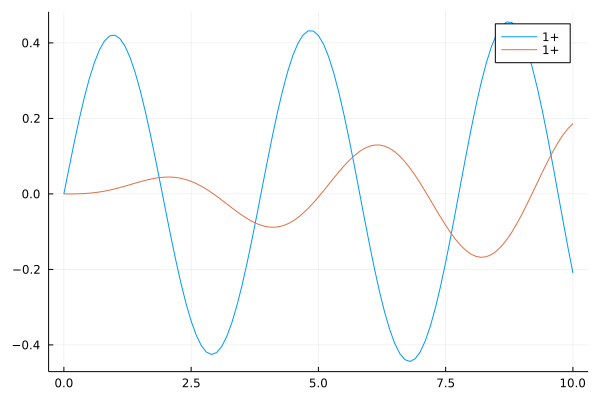

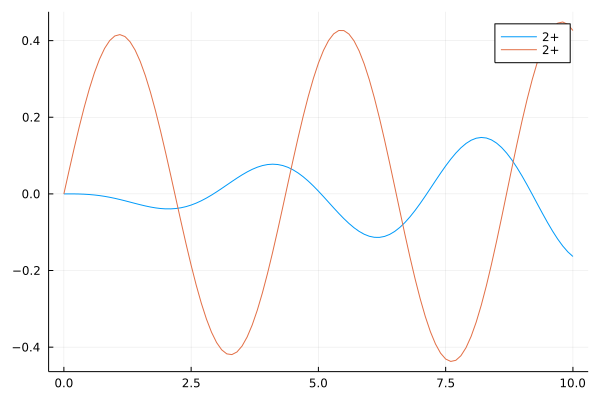

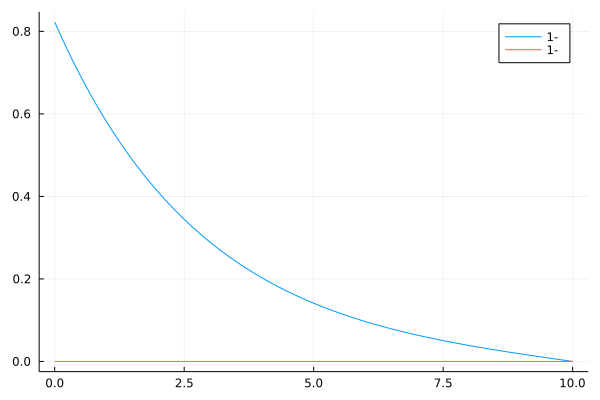

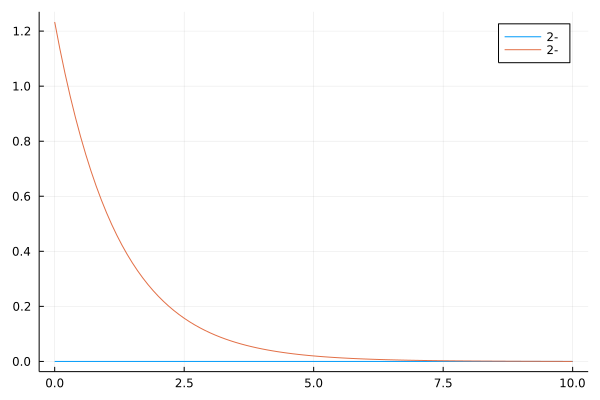

  0.000032 seconds


In [6]:
test_integrate_HFBeq!(param; E = 5.6)

In [7]:
function calc_matching_matrix(param)
    @unpack Δr, ir_matching, ys_1p, ys_2p, ys_1m, ys_2m = param
    
    ir = ir_matching
    
    M11 =  ys_1p[1,ir]
    M12 =  ys_2p[1,ir]
    M13 = -ys_1m[1,ir]
    M14 = -ys_2m[1,ir]
    
    M21 =  ys_1p[2,ir]
    M22 =  ys_2p[2,ir]
    M23 = -ys_1m[2,ir]
    M24 = -ys_2m[2,ir]
    
    M31 =  (ys_1p[1,ir+1] - ys_1p[1,ir-1])/2Δr
    M32 =  (ys_2p[1,ir+1] - ys_2p[1,ir-1])/2Δr
    M33 = -(ys_1m[1,ir+1] - ys_1m[1,ir-1])/2Δr
    M34 = -(ys_2m[1,ir+1] - ys_2m[1,ir-1])/2Δr
    
    M41 =  (ys_1p[2,ir+1] - ys_1p[2,ir-1])/2Δr
    M42 =  (ys_2p[2,ir+1] - ys_2p[2,ir-1])/2Δr
    M43 = -(ys_1m[2,ir+1] - ys_1m[2,ir-1])/2Δr
    M44 = -(ys_2m[2,ir+1] - ys_2m[2,ir-1])/2Δr
    
    M₄ = SA_F64[M11 M12 M13 M14;
                M21 M22 M23 M24;
                M31 M32 M33 M34;
                M41 M42 M43 M44]
end

function test_calc_matching_matrix!(param, Es)
    @unpack Nr, Δr, ys_1p, ys_2p, ys_1m, ys_2m = param
    
    dets = similar(Es)
    
    for iE in 1:length(Es)
        integrate_HFBeq!(param, Es[iE])
        
        M₄ = calc_matching_matrix(param)
        
        dets[iE] = det(M₄)
    end
    return dets
end

test_calc_matching_matrix! (generic function with 1 method)

┌ Warning: Keyword argument markerstrokestyle not supported with Plots.GRBackend().  Choose from: Set([:top_margin, :group, :inset_subplots, :background_color, :ytickfontsize, :yforeground_color_text, :yguidefontcolor, :tickfontfamily, :show_empty_bins, :seriesalpha, :seriescolor, :ztick_direction, :xgrid, :ygridalpha, :zlims, :xtick_direction, :colorbar, :legend_font_family, :zflip, :ticks, :linealpha, :overwrite_figure, :arrow, :xguidefonthalign, :normalize, :linestyle, :xtickfontvalign, :xflip, :zgrid, :fillcolor, :ygrid, :bar_width, :colorbar_scale, :background_color_inside, :zguidefonthalign, :bins, :zguide, :zforeground_color_text, :legend_font_valign, :yscale, :legend_font_color, :weights, :xgridalpha, :ygridstyle, :clims, :xtickfontcolor, :fill_z, :xguide, :markershape, :background_color_subplot, :ztickfontfamily, :fillalpha, :markerstrokewidth, :tick_direction, :xguidefontvalign, :xguidefontfamily, :gridlinewidth, :foreground_color_subplot, :xgridlinewidth, :yguidefontsize, :f

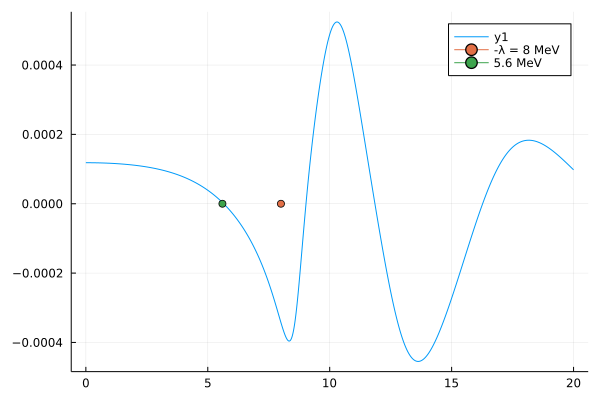

In [8]:
param = My.PhysicalParam(V₀ = -3, Nr=200, Δr=0.1)
Es = 0:0.01:20
dets = test_calc_matching_matrix!(param, Es)
plot(Es, dets)
plot!([8],[0]; marker=:dot, label="-λ = 8 MeV")
plot!([5.6],[0]; marker=:dot, label="5.6 MeV")

In [9]:
function construct_eigenfunction!(ys, param, E; eps=1e-10)
    @unpack Nr, Δr, ir_matching, ys_1p, ys_2p, ys_1m, ys_2m = param
    
    integrate_HFBeq!(param, E)
    
    M₄ = calc_matching_matrix(param)
    
    M₃ = SA_F64[M₄[2,2] M₄[2,3] M₄[2,4];
                M₄[3,2] M₄[3,3] M₄[3,4];
                M₄[4,2] M₄[4,3] M₄[4,4]]
    
    v₃ = SA_F64[-M₄[2,1], -M₄[3,1], -M₄[4,1]]
    v₃ = M₃\v₃
    
    A = 1
    B = v₃[1]
    C = v₃[2]
    D = v₃[3]
    
    a = M₄*SA_F64[A, B, C, D]
    
    if norm(a) > eps
        M₃ = SA_F64[M₄[1,1] M₄[1,3] M₄[1,4];
                    M₄[3,1] M₄[3,3] M₄[3,4];
                    M₄[4,1] M₄[4,3] M₄[4,4]]

        v₃ = SA_F64[-M₄[1,2], -M₄[3,2], -M₄[4,2]]
        v₃ = M₃\v₃

        A = v₃[1]
        B = 1
        C = v₃[2]
        D = v₃[3]
    end
    
    
    for ir in 1:ir_matching
        @views @. ys[:,ir] = A*ys_1p[:,ir] + B*ys_2p[:,ir]
    end
    for ir in ir_matching+1:Nr+1
        @views @. ys[:,ir] = C*ys_1m[:,ir] + D*ys_2m[:,ir]
    end

end

function shooting!(param, states, Es; eps=1e-10)
    @unpack rs = param
    @unpack qpEs, wfs = states
    
    function f(E)
        integrate_HFBeq!(param, E)
        M₄ = calc_matching_matrix(param)
        return det(M₄)
    end
    
    istate = 0
    for i in 1:length(Es)-1
        d₁ = f(Es[i])
        d₂ = f(Es[i+1])
        
        @views if d₁*d₂ < 0
            E = find_zero(f, (Es[i], Es[i+1]), Bisection())
            if abs(f(E)) > eps 
                continue 
            end
            istate += 1
            qpEs[istate] = E
            construct_eigenfunction!(wfs[:,:,istate], param, E)
            normalize!(wfs[:,:,istate], rs)
        end
    end
end

function plot_states(param, states)
    @unpack rs, Δr = param 
    @unpack nstates_max, qpEs, wfs = states
    
    for istate in 1:nstates_max
        if qpEs[istate] > 1000
            break
        end
        p = plot()
        plot!(rs, wfs[1,:,istate])
        plot!(rs, wfs[2,:,istate])
        
        u = sqrt(sum(@. wfs[1,:,istate]^2)*Δr)
        v = sqrt(sum(@. wfs[2,:,istate]^2)*Δr)
        @show u v sqrt(u*u + v*v)
        display(p)
    end
end

plot_states (generic function with 1 method)

In [10]:
Es = 0.0:0.1:50
param = My.PhysicalParam(V₀ = -3.0, λ=-8, Nr=200, Δr=0.1)
states = make_HFBstates(param)
@time shooting!(param, states, Es)
states.qpEs[states.qpEs .≠ 1e10]

  0.764250 seconds (5.82 M allocations: 302.809 MiB, 5.99% gc time, 92.07% compilation time)


10-element Vector{Float64}:
  5.652814078522799
  9.027552862821855
 11.85406395692822
 16.270662229601374
 22.12975880882694
 22.567309061992745
 29.423263714607007
 37.61266810925225
 40.843668527294895
 46.218445175808434

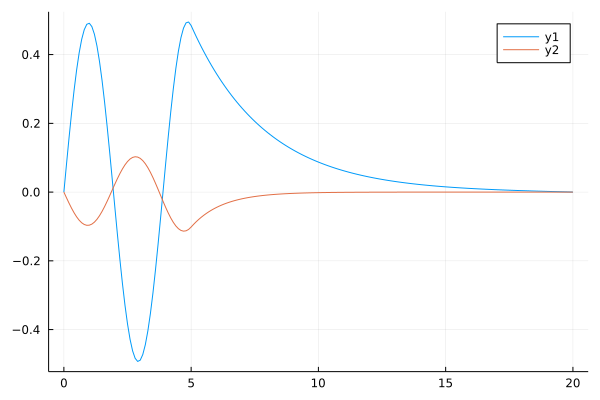

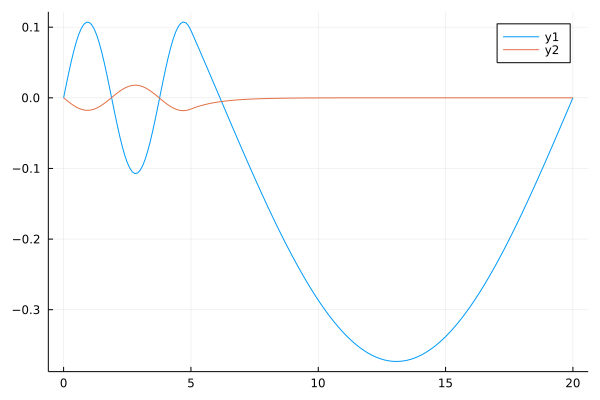

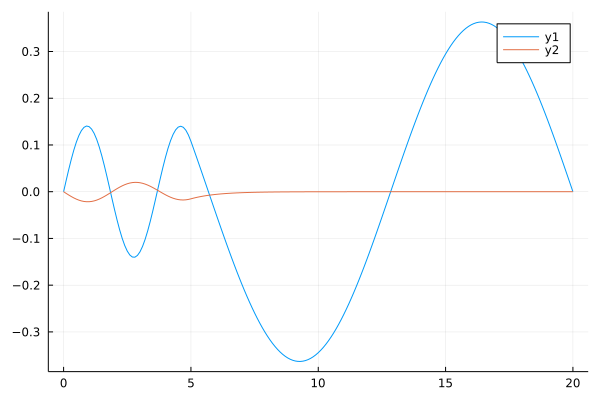

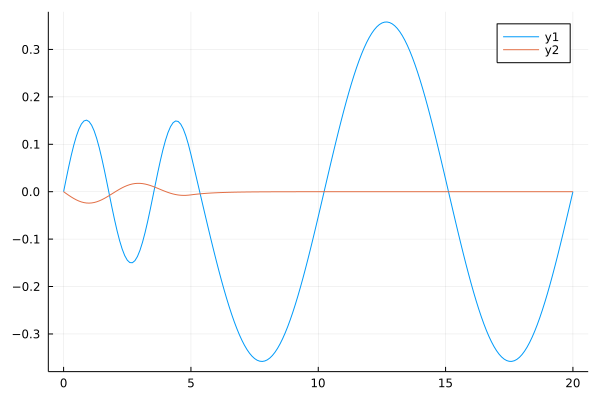

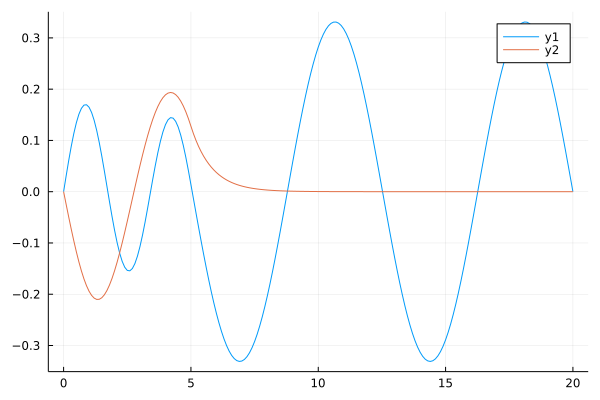

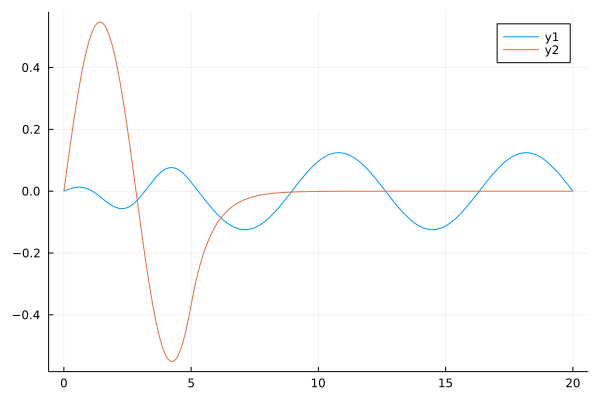

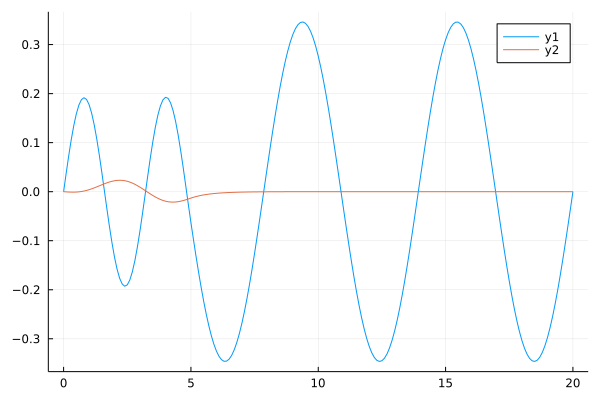

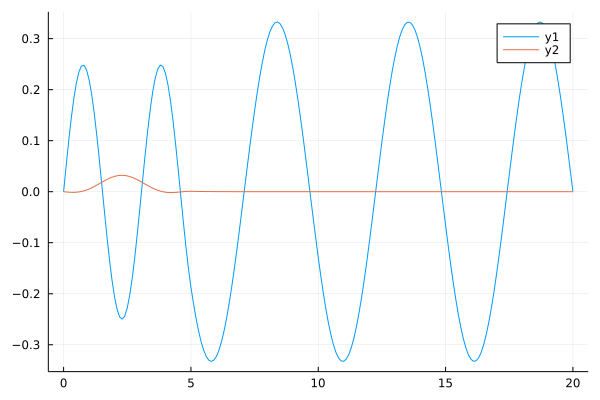

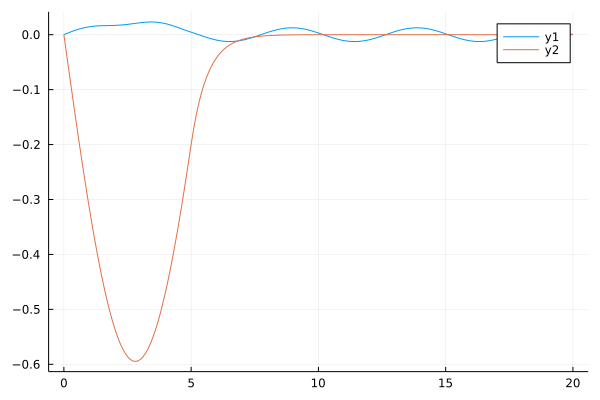

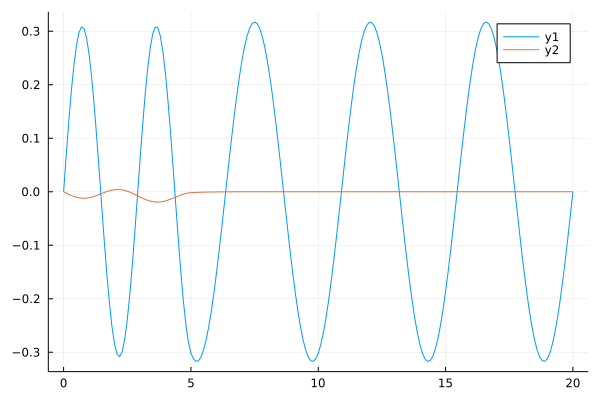

u = 0.9825608195010632
v = 0.18594148536945618
sqrt(u * u + v * v) = 1.0000000000000002
u = 0.9995094190723586
v = 0.03131966132697699
sqrt(u * u + v * v) = 1.0
u = 0.9994187394709052
v = 0.03409080806297982
sqrt(u * u + v * v) = 1.0
u = 0.9995278803628023
v = 0.030724849510505668
sqrt(u * u + v * v) = 0.9999999999999998
u = 0.9389849788862094
v = 0.34395815068997043
sqrt(u * u + v * v) = 0.9999999999999997
u = 0.35124009808262524
v = 0.9362854230943184
sqrt(u * u + v * v) = 0.9999999999999994
u = 0.9994187220527737
v = 0.03409131869553066
sqrt(u * u + v * v) = 0.9999999999999998
u = 0.999322789298979
v = 0.03679623333588485
sqrt(u * u + v * v) = 1.0000000000000002
u = 0.050369451919003994
v = 0.9987306535364673
sqrt(u * u + v * v) = 0.9999999999999999
u = 0.999735755525556
v = 0.02298736878690632
sqrt(u * u + v * v) = 0.9999999999999998


In [11]:
plot_states(param, states)